In [1]:
from scipy.integrate import odeint
import numpy as np
import theano
from theano import *
import matplotlib.pyplot as plt
import pymc3 as pm

THEANO_FLAGS='optimizer=fast_compile'

In [2]:
class LotkaVolterraModel(object):
    def __init__(self, y0=None):
        self._y0 = y0

    def simulate(self, parameters, times):
        alpha, beta, gamma, delta, Xt0, Yt0 = [x for x in parameters]
        def rhs(y, t, p):
            X, Y = y
            dX_dt = alpha*X - beta*X*Y
            dY_dt = -gamma*Y + delta*X*Y
            return dX_dt, dY_dt

        values = odeint(rhs, [Xt0, Yt0], times, (parameters,))
        return values
ode_model = LotkaVolterraModel()

In [3]:
n_states = 2
n_odeparams = 4
n_ivs = 2

class LotkaVolterraModel(object):
    def __init__(self, n_states, n_odeparams, n_ivs, y0=None):
        self._n_states = n_states
        self._n_odeparams = n_odeparams
        self._n_ivs = n_ivs
        self._y0 = y0
    def simulate(self, parameters, times):
        return self._simulate(parameters, times, False)
    def simulate_with_sensitivities(self, parameters, times):
        return self._simulate(parameters, times, True)
    def _simulate(self, parameters, times, sensitivities):
        alpha, beta, gamma, delta, Xt0, Yt0 = [x for x in parameters]
        def r(y, t, p):
            X, Y = y
            dX_dt = alpha*X - beta*X*Y
            dY_dt = -gamma*Y + delta*X*Y
            return dX_dt, dY_dt
        if sensitivities:
            def jac(y):
                X, Y = y
                ret = np.zeros((self._n_states, self._n_states))
                ret[0, 0] = alpha - beta*Y
                ret[0, 1] = - beta*X
                ret[1, 0] = delta*Y
                ret[1, 1] = -gamma + delta*X
                return ret
            def dfdp(y):
                X, Y = y
                ret = np.zeros((self._n_states,
                                self._n_odeparams + self._n_ivs)) # except the following entries
                ret[0, 0] = X      # \frac{\partial  [\alpha X - \beta XY]}{\partial \alpha}, and so on...
                ret[0, 1] = - X*Y
                ret[1, 2] = -Y
                ret[1, 3] = X*Y

                return ret
            def rhs(y_and_dydp, t, p):
                y = y_and_dydp[0:self._n_states]
                dydp = y_and_dydp[self._n_states:].reshape((self._n_states,
                                                            self._n_odeparams + self._n_ivs))
                dydt = r(y, t, p)
                d_dydp_dt = np.matmul(jac(y), dydp) + dfdp(y)
                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))
            y0 = np.zeros( (2*(n_odeparams+n_ivs)) + n_states )
            y0[6] = 1.            #\frac{\partial  [X]}{\partial Xt0} at t==0, and same below for Y
            y0[13] = 1.
            y0[0:n_states] = [Xt0, Yt0]
            result = odeint(rhs, y0, times, (parameters,),rtol=1e-6,atol=1e-5)
            values = result[:, 0:self._n_states]
            dvalues_dp = result[:, self._n_states:].reshape((len(times),
                                                             self._n_states,
                                                             self._n_odeparams + self._n_ivs))
            return values, dvalues_dp
        else:
            values = odeint(r, [Xt0, Yt0], times, (parameters,),rtol=1e-6,atol=1e-5)
            return values
ode_model = LotkaVolterraModel(n_states, n_odeparams, n_ivs)

In [4]:
class ODEGradop(theano.Op):
    def __init__(self, numpy_vsp):
        self._numpy_vsp = numpy_vsp

    def make_node(self, x, g):
        x = theano.tensor.as_tensor_variable(x)
        g = theano.tensor.as_tensor_variable(g)
        node = theano.Apply(self, [x, g], [g.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]

        g = inputs_storage[1]
        out = output_storage[0]
        out[0] = self._numpy_vsp(x, g)       # get the numerical VSP

class ODEop(theano.Op):

    def __init__(self, state, numpy_vsp):
        self._state = state
        self._numpy_vsp = numpy_vsp

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)

        return theano.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]

        out[0] = self._state(x)               # get the numerical solution of ODE states

    def grad(self, inputs, output_grads):
        x = inputs[0]
        g = output_grads[0]

        grad_op = ODEGradop(self._numpy_vsp)  # pass the VSP when asked for gradient
        grad_op_apply = grad_op(x, g)

        return [grad_op_apply]

In [5]:
class solveCached(object):
    def __init__(self, times, n_params, n_outputs):

        self._times = times
        self._n_params = n_params
        self._n_outputs = n_outputs
        self._cachedParam = np.zeros(n_params)
        self._cachedSens = np.zeros((len(times), n_outputs, n_params))
        self._cachedState = np.zeros((len(times),n_outputs))

    def __call__(self, x):

        if np.all(x==self._cachedParam):
            state, sens = self._cachedState, self._cachedSens

        else:
            state, sens = ode_model.simulate_with_sensitivities(x, times)

        return state, sens
times = np.arange(0, 21) # number of measurement points (see below)
cached_solver=solveCached(times, n_odeparams + n_ivs, n_states)

In [7]:
def state(x):
    State, Sens = cached_solver(np.array(x,dtype=np.float64))
    cached_solver._cachedState, cached_solver._cachedSens, cached_solver._cachedParam = State, Sens, x
    return State.reshape((2*len(State),))

def numpy_vsp(x, g):
    numpy_sens = cached_solver(np.array(x,dtype=np.float64))[1].reshape((n_states*len(times),len(x)))
    return numpy_sens.T.dot(g)

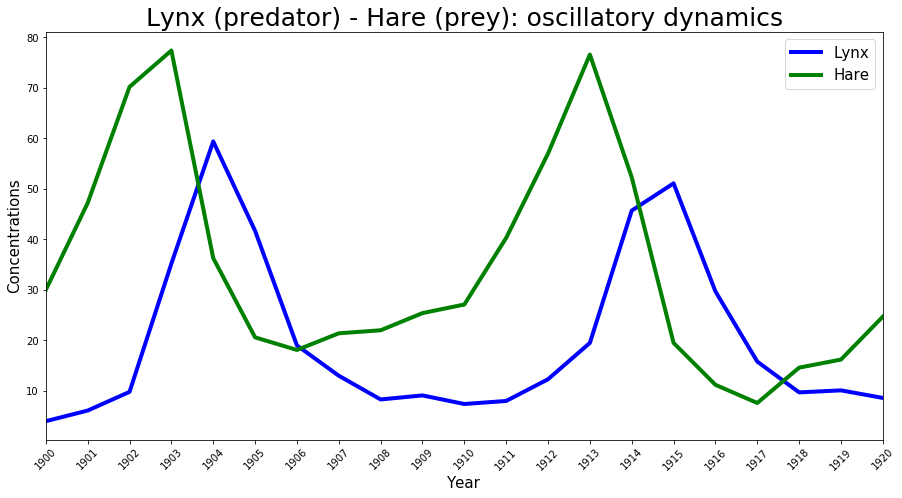

In [8]:
Year = np.arange(1900,1921,1)
Lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
Hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
plt.figure(figsize=(15, 7.5))
plt.plot(Year,Lynx,color='b', lw=4, label='Lynx')
plt.plot(Year,Hare,color='g', lw=4, label='Hare')
plt.legend(fontsize=15)
plt.xlim([1900,1920])
plt.xlabel('Year', fontsize=15)
plt.ylabel('Concentrations', fontsize=15)
plt.xticks(Year,rotation=45)
plt.title('Lynx (predator) - Hare (prey): oscillatory dynamics', fontsize=25);

In [9]:
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'


# Define the data matrix
Y = np.vstack((Hare,Lynx)).T

# Now instantiate the theano custom ODE op
my_ODEop = ODEop(state,numpy_vsp)

# The probabilistic model
with pm.Model() as LV_model:

    # Priors for unknown model parameters

    alpha =  pm.Normal('alpha', mu=1, sd=0.5)
    beta =  pm.Normal('beta', mu=0.05, sd=0.05)
    gamma =  pm.Normal('gamma', mu=1, sd=0.5)
    delta =  pm.Normal('delta', mu=0.05, sd=0.05)

    xt0 = pm.Lognormal('xto', mu=np.log(10), sd=1)
    yt0 = pm.Lognormal('yto', mu=np.log(10), sd=1)
    sigma = pm.Lognormal('sigma', mu=-1, sd=1, shape=2)

    # Forward model
    all_params = pm.math.stack([alpha,beta,gamma,delta,xt0,yt0],axis=0)
    ode_sol = my_ODEop(all_params)
    forward = ode_sol.reshape(Y.shape)

    # Likelihood
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)

    trace = pm.sample(1500, tune=1000, init='adapt_diag')
trace['diverging'].sum()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, yto, xto, delta, gamma, beta, alpha]
Sampling 4 chains, 0 divergences:   0%|          | 0/10000 [00:00<?, ?draws/s]/Users/hstrey/anaconda3/envs/fMRI/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Sampling 4 chains, 0 divergences:   2%|▏         | 234/10000 [01:07<38:54,  4.18draws/s]  /Users/hstrey/anaconda3/envs/fMRI/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Sampling 4 chains, 0 divergences:   6%|▋         | 644/10000 [02:26<12:51, 12.12draws/s]  /Users/hstrey/anaconda3/envs/fMRI/lib/pytho

164

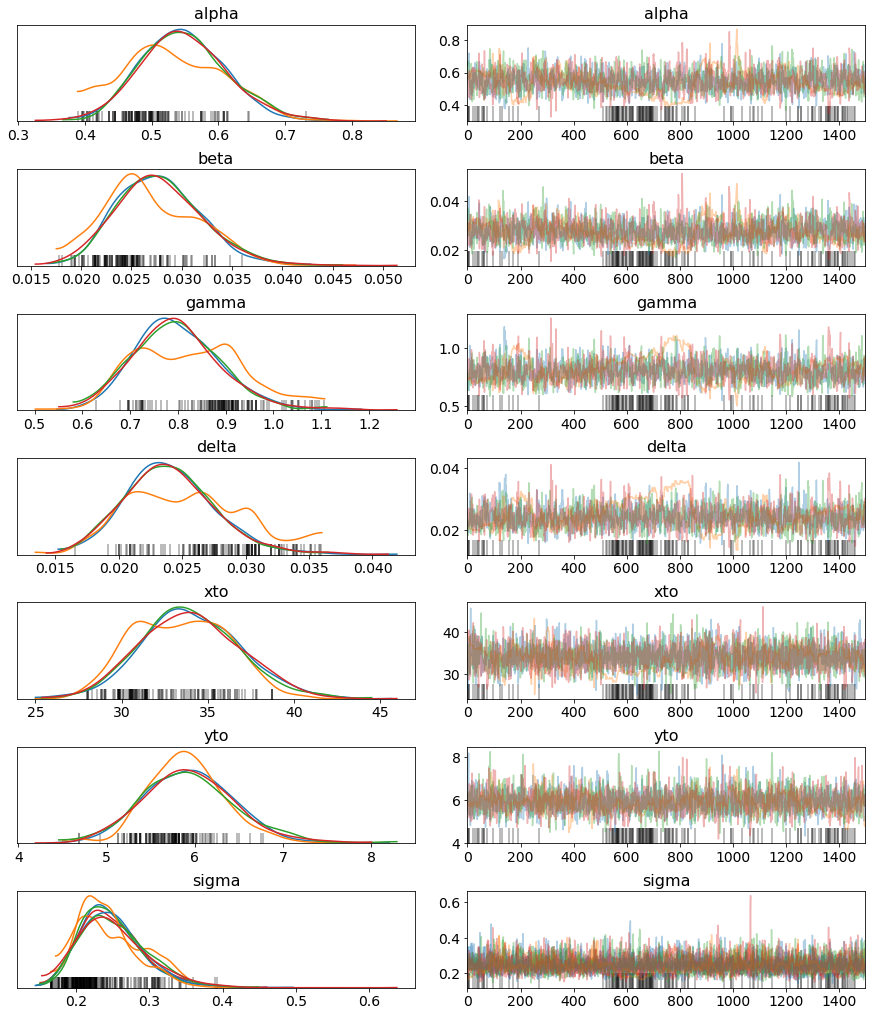

In [10]:
with LV_model:
    pm.traceplot(trace);

In [11]:
import pandas as pd
summary = pm.summary(trace)
STAN_mus = [0.549, 0.028, 0.797, 0.024, 33.960, 5.949, 0.248, 0.252]
STAN_sds = [0.065, 0.004, 0.091, 0.004, 2.909, 0.533, 0.045, 0.044]
summary['STAN_mus'] = pd.Series(np.array(STAN_mus), index=summary.index)
summary['STAN_sds'] = pd.Series(np.array(STAN_sds), index=summary.index)
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,STAN_mus,STAN_sds
alpha,0.545,0.068,0.412,0.664,0.004,0.003,261.0,261.0,249.0,182.0,1.01,0.549,0.065
beta,0.028,0.004,0.020,0.036,0.000,0.000,308.0,308.0,287.0,287.0,1.01,0.028,0.004
gamma,0.805,0.097,0.628,0.985,0.007,0.005,211.0,200.0,231.0,188.0,1.02,0.797,0.091
delta,0.024,0.004,0.017,0.032,0.000,0.000,182.0,166.0,208.0,172.0,1.02,0.024,0.004
xto,33.871,2.838,28.773,39.151,0.138,0.097,425.0,425.0,392.0,886.0,1.01,33.960,2.909
yto,5.933,0.507,5.001,6.919,0.017,0.012,929.0,929.0,857.0,2199.0,1.01,5.949,0.533
sigma[0],0.249,0.044,0.174,0.331,0.003,0.002,257.0,257.0,237.0,374.0,1.01,0.248,0.045
sigma[1],0.249,0.045,0.176,0.335,0.002,0.001,720.0,720.0,534.0,786.0,1.01,0.252,0.044


In [12]:
ppc_samples = pm.sample_posterior_predictive(trace, samples=1000, model=LV_model)['Y_obs']
mean_ppc = ppc_samples.mean(axis=0)
CriL_ppc = np.percentile(ppc_samples,q=2.5,axis=0)
CriU_ppc = np.percentile(ppc_samples,q=97.5,axis=0)

/Users/hstrey/anaconda3/envs/fMRI/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:09<00:00, 110.95it/s]


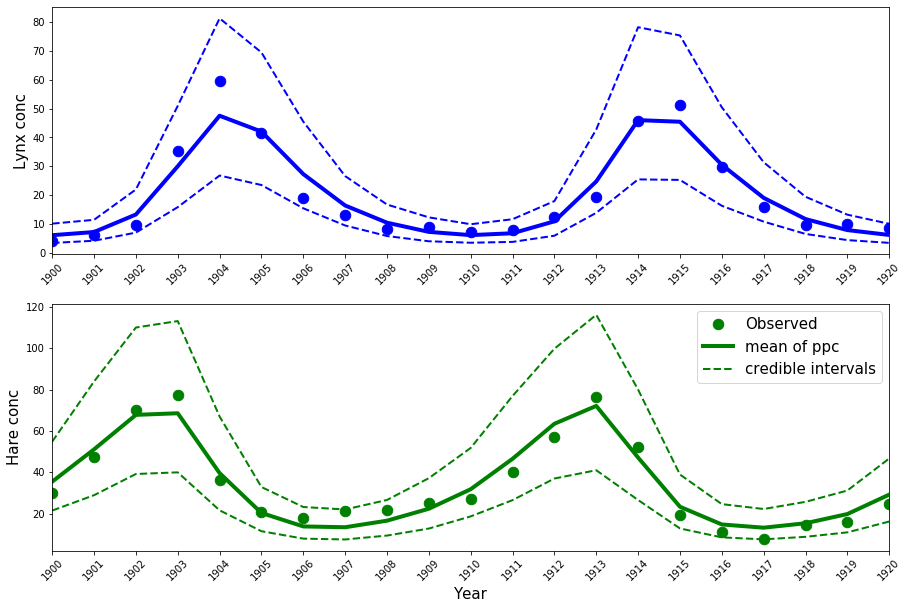

In [13]:
plt.figure(figsize=(15, 2*(5)))
plt.subplot(2,1,1)
plt.plot(Year,Lynx,'o', color='b', lw=4, ms=10.5)
plt.plot(Year,mean_ppc[:,1], color='b', lw=4)
plt.plot(Year,CriL_ppc[:,1], '--', color='b', lw=2)
plt.plot(Year,CriU_ppc[:,1], '--',  color='b', lw=2)
plt.xlim([1900,1920])
plt.ylabel('Lynx conc', fontsize=15)
plt.xticks(Year,rotation=45);
plt.subplot(2,1,2)
plt.plot(Year,Hare,'o', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(Year,mean_ppc[:,0], color='g', lw=4, label='mean of ppc')
plt.plot(Year,CriL_ppc[:,0], '--',  color='g', lw=2, label='credible intervals')
plt.plot(Year,CriU_ppc[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15)
plt.xlim([1900,1920])
plt.xlabel('Year', fontsize=15)
plt.ylabel('Hare conc', fontsize=15)
plt.xticks(Year,rotation=45);